<a href="https://colab.research.google.com/github/spdsp04/melanoma_detection_Durgesh_Chaubey_CNN/blob/main/Durgesh_Chaubey_CNN_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement (Melanoma Detection)



>To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

>The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

>The data set contains the following diseases:

>- Actinic keratosis
>- Basal cell carcinoma
>- Dermatofibroma
>- Melanoma
>- Nevus
>- Pigmented benign keratosis
>- Seborrheic keratosis
>- Squamous cell carcinoma
>- Vascular lesion

### Importing Dataset 

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Checking versions of Libraries
f'NumPy version: {np.__version__} | Pandas version: {pd.__version__} | keras version: {keras.__version__}'

'NumPy version: 1.21.6 | Pandas version: 1.3.5 | keras version: 2.8.0'

In [4]:
# Importing from local machine
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
# to count total no of images in dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Defining dataset**

Define some batch size, height and width of image to load

In [6]:
batch_size = 32
img_height = 180
img_width = 180

**Image loading by using keras.preprocessing**

Image to be loaded off from dataset by image_dataset_from_directory utility.

Splitting 80% of the data for training the model and 20% for validation segment.

In [7]:
# segmenting train and validation set from dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Segregation of validation set from dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Classifying all type of skin cancer
Name_of_class = train_dataset.class_names
print(Name_of_class)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
# Coutning no's of images in each class type of Train datset
for i in Name_of_class:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


In [11]:
# Coutning no's of images in each class type of Test datset
for i in Name_of_class:
  print(i,": ",len(list(data_dir_test.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  16
basal cell carcinoma :  16
dermatofibroma :  16
melanoma :  16
nevus :  16
pigmented benign keratosis :  16
seborrheic keratosis :  3
squamous cell carcinoma :  16
vascular lesion :  3


### Data Visulisation   

Having random view of each type of Images

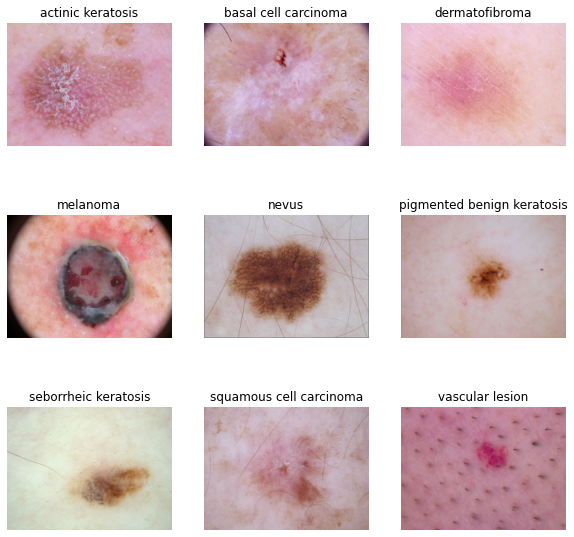

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for index,images in enumerate(Name_of_class):
  
  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
  
  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)
  

In [13]:
# to confirm shape and size of Image
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


A tensor of the size (32, 180, 180, 3) is dimension of one image batch. Here it is group of 32 images with dimension 180x180x3 (the last one is for color channels RGB).

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset= validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

#Dataset.prefetch() overlaps data preprocessing and model execution while training.

**Standardization of images**

The RGB channel values ranges in between 0 to 225, which is not good in case of neural network. Ideally it should be in between 0 and 1.

In [15]:
normalised_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset = train_dataset.map(lambda x, y: (normalised_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))

### Model 1

Creating First model to identify total 9 classes in dataset.

In [16]:
model=Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(16, 3, activation='relu',padding='same', input_shape = (180, 180, 32)))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

**Compilation of Model**

Using adam as optimiser and loss function to train the Model

In [17]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
# Checking summery of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the Model after optimising with 20 epochs

In [19]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 66s 979ms/step - loss: 1.9873 - accuracy: 0.2779 - val_loss: 1.8092 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.6780 - accuracy: 0.3906 - val_loss: 1.6134 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5400 - accuracy: 0.4615 - val_loss: 1.6274 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3673 - accuracy: 0.5301 - val_loss: 1.4941 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2999 - accuracy: 0.5552 - val_loss: 1.3890 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.1805 - accuracy: 0.5826 - val_loss: 1.3311 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.0715 - accuracy: 0.6228 - val_loss: 1.4311 - val_accuracy: 0.5570
Epoch 8/20


### Checking results of Model 1

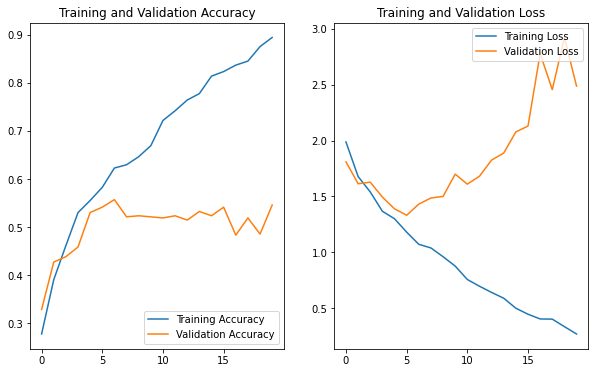

In [20]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Train Data Accuracy : 0.8940

Train Loss : 0.2896

Validation Data Accuracy : 0.5503

Validation Loss - 2.2613

**Nutshell:** 

Accuracy figures indicates that model is highly overfit, secondly loss value of validation dataset is higher.

**Correction:**
Model need augmentation also dropout in layers.

### Data Augmentation

Augmentation is kind of apply flip, rotate, zoom for data input while model building, to enhance result.

In [21]:
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

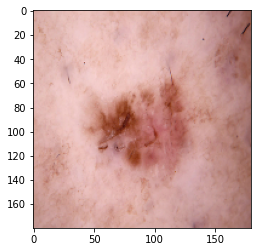

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_augmentation1=ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2)
image_batch,label_batch=next(iter(train_dataset))
temp=image_batch[0].numpy()
plt.imshow(temp.astype('uint8'))

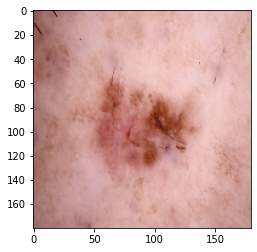

In [23]:
#Checking effect of augmentation on one of image
plt.imshow(data_augmentation1.apply_transform(temp,transform_parameters={'flip_horizontal':True}).astype('uint8'))

### Building Model 2 after Augmentation

In [24]:
Augmented_data_model=Sequential([data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
Augmented_data_model.add(Conv2D(16, 3, activation='relu',padding='same',input_shape = (180, 180, 32)))
Augmented_data_model.add(MaxPooling2D())

Augmented_data_model.add(Conv2D(32, 3, activation='relu',padding='same'))
Augmented_data_model.add(MaxPooling2D())
Augmented_data_model.add(Conv2D(64, 3, activation='relu',padding='same'))
Augmented_data_model.add(MaxPooling2D())
Augmented_data_model.add(Dropout(0.25))

Augmented_data_model.add(Flatten())
Augmented_data_model.add(Dense(128, activation='relu'))
Augmented_data_model.add(Dense(9, activation='softmax'))


In [25]:
#Compiling the model built after data augmentation
Augmented_data_model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
# Checking summary of Model built by augmenting data
Augmented_data_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
# Training model after data augmentation with 20 epoches
epochs = 20
history = Augmented_data_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 60ms/step - loss: 1.9247 - accuracy: 0.3069 - val_loss: 1.7387 - val_accuracy: 0.4027
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 1.6570 - accuracy: 0.4001 - val_loss: 1.5773 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5130 - accuracy: 0.4576 - val_loss: 1.4504 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4267 - accuracy: 0.4950 - val_loss: 1.4055 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.3607 - accuracy: 0.5162 - val_loss: 1.4366 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.3920 - accuracy: 0.5218 - val_loss: 1.3952 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3126 - accuracy: 0.5312 - val_loss: 1.3170 - val_accuracy: 0.5369
Epoch 8/20
56

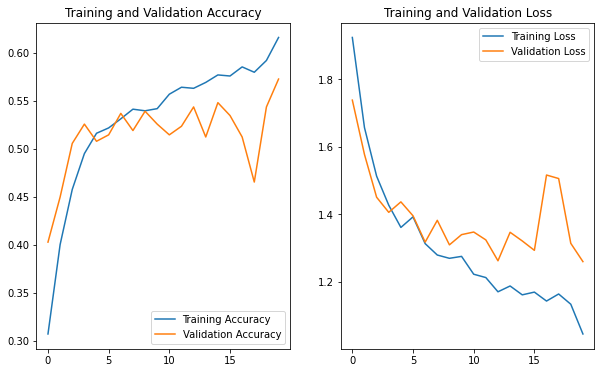

In [28]:
# Visualizing the result
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

Train Data Accuracy : 0.5943

Train Loss : 1.1204

Validation Data Accuracy : 0.5526

Validation Loss - 1.3108

**Nutshell:** 

Accuracy figures indicates that model is not good enough, although model is behaving almost in same way on train and validation dataset.

**Correction:**
Data imbalancing to be checked.

### Class Imbalance checking

Numerous datasets can have class awkwardness, one class can have proportionately larger number of tests contrasted with the others. Class irregularity can unfavorably affect the last model quality. Consequently as a second look just in case it becomes essential to actually look at what is the dispersion of classes in the information.

In [29]:
for i in Name_of_class:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


<BarContainer object of 9 artists>

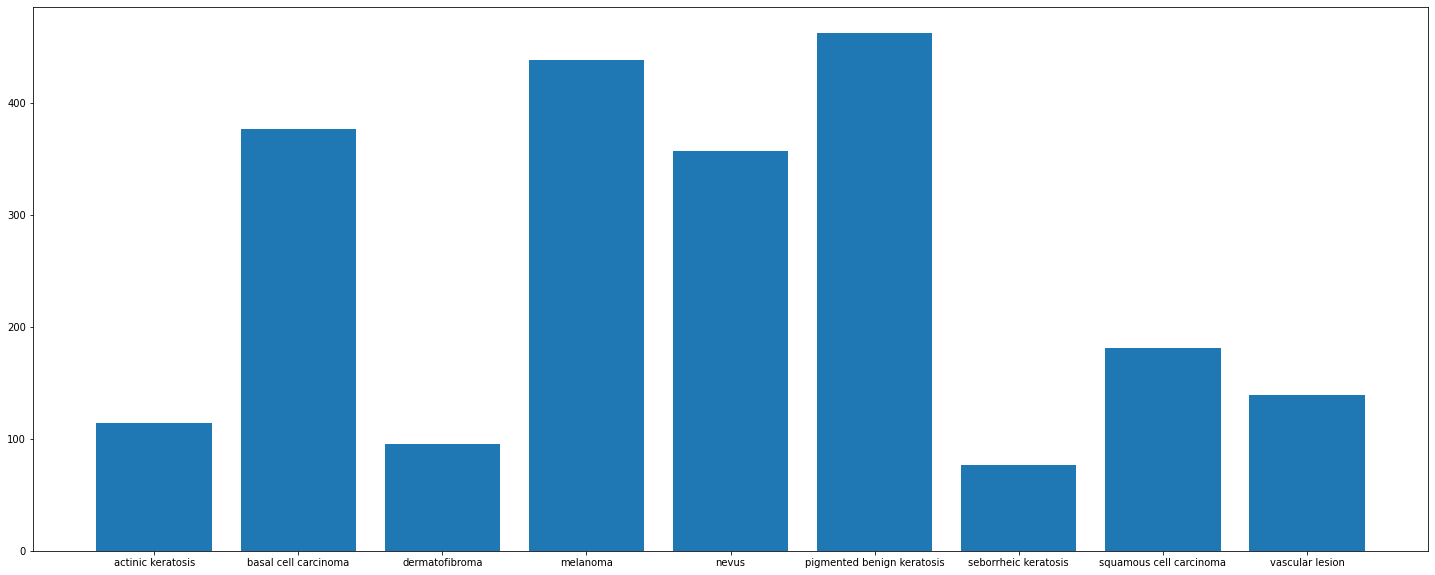

In [30]:
# Visualize class imbalance through chart
count=[]
for i in Name_of_class:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(Name_of_class,count)

**'seborrheic keratosis'** is having the least no of images i,e 77

**'pigmented benign keratosis'** is having the maximum no of images i,e 462 

In [31]:
# lebel checking
path_list=[]
lesion_list=[]
for i in Name_of_class:
      for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion


**Augmentor Package**

A python package known as Augmentor is utilized to add more examples across all classes with the goal that none of the classes have not many examples.

Procedure to use Agumentor:

1. Start pipeline to folder of sample image
2. Mention nos of operation to be done on pipline object.
3. Call the method

In [34]:
import Augmentor
for i in Name_of_class:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  augmnt_pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD45D5C6910>: 100%|██████████| 500/500 [00:31<00:00, 15.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD45FBE9590>: 100%|██████████| 500/500 [00:32<00:00, 15.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD45F12D990>: 100%|██████████| 500/500 [00:31<00:00, 16.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD4D9681410>: 100%|██████████| 500/500 [02:03<00:00,  4.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FD45D697390>: 100%|██████████| 500/500 [01:50<00:00,  4.53 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD45DF1D1D0>: 100%|██████████| 500/500 [00:24<00:00, 20.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD45D6E41D0>: 100%|██████████| 500/500 [00:56<00:00,  8.86 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD45DF742D0>: 100%|██████████| 500/500 [00:24<00:00, 20.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4D9664DD0>: 100%|██████████| 500/500 [00:24<00:00, 20.01 Samples/s]


Augmentor has stored agumented images in the new subfolder output folder of each class folder. Lets have count for total.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Checking distribution of augmented data after adding new images to the original training data.**

In [36]:
import os
import glob
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance.

In [41]:
batch_size = 32
img_height = 180
img_width = 180

**Splitting Training dataset**

In [42]:
augmented_data_dir = data_dir_train
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**segmenting train and validation set from dataset**

In [43]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Building Model 3 After additional 500 images in output folder

In [44]:
# Include BatchNormalization, Dropout
Normalised_Model=Sequential()

Normalised_Model.add(InputLayer((180,180,3)))
Normalised_Model.add(Rescaling(1./255))

Normalised_Model.add(Conv2D(32, (3, 3), padding='same'))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))

Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))

Normalised_Model.add(Conv2D(64, (3, 3)))
Normalised_Model.add(BatchNormalization())
Normalised_Model.add(Activation('relu'))


Normalised_Model.add(MaxPooling2D(pool_size=(2, 2)))
Normalised_Model.add(Dropout(0.25))

Normalised_Model.add(Flatten())
Normalised_Model.add(Dense(512, activation='relu'))
Normalised_Model.add(Dense(256, activation='relu'))
Normalised_Model.add(Dropout(0.25))

Normalised_Model.add(Dense(9, activation='softmax'))


# having glance on layer summery
Normalised_Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 64)       

### Compiling the 3rd model built after after adding 500 additinal images with adam optimiser

In [45]:
Normalised_Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the 3rd model built after after adding 500 additinal images with 50 epoches

In [46]:
epochs = 30
history = Normalised_Model.fit(
  train_dataset,
  validation_data=validation_dataset ,
  epochs=epochs,
)


Epoch 1/30
169/169 [==============================] - 46s 257ms/step - loss: 8.8484 - accuracy: 0.2357 - val_loss: 2.2197 - val_accuracy: 0.1522
Epoch 2/30
169/169 [==============================] - 43s 249ms/step - loss: 1.8551 - accuracy: 0.2954 - val_loss: 1.9661 - val_accuracy: 0.2747
Epoch 3/30
169/169 [==============================] - 42s 242ms/step - loss: 1.6666 - accuracy: 0.3613 - val_loss: 1.6528 - val_accuracy: 0.3660
Epoch 4/30
169/169 [==============================] - 42s 242ms/step - loss: 1.6104 - accuracy: 0.3767 - val_loss: 1.5058 - val_accuracy: 0.4358
Epoch 5/30
169/169 [==============================] - 45s 259ms/step - loss: 1.5248 - accuracy: 0.4028 - val_loss: 2.1928 - val_accuracy: 0.3779
Epoch 6/30
169/169 [==============================] - 42s 243ms/step - loss: 1.4227 - accuracy: 0.4540 - val_loss: 1.3526 - val_accuracy: 0.4855
Epoch 7/30
169/169 [==============================] - 42s 243ms/step - loss: 1.4384 - accuracy: 0.4351 - val_loss: 1.3944 - val_ac

**Visualizing the result**

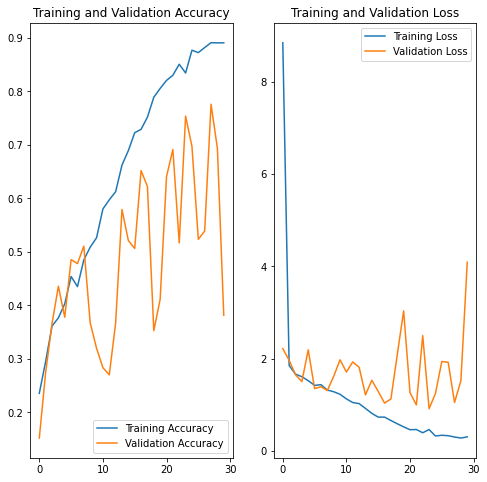

In [47]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Result:**

Train Accuracy - 0.91

Validation Accuracy - 0.79

Train Loss - 0.21

Validation Loss - 0.92

**Findings:**

From the above result we come to know this model's validation accuracy is increased when compared to previous models. But this model is also overfitting.

Using class rebalance, droupout, batch normalization helps in acheiving the better result than simple model.

**Solution:**

The Model can be further improved by tuning the hyperparameter.

## Conclusion:

We observe successive improvement from Model 1 to Model 3:

**Model 1:** Simple CNN Model 

Accuracy: 0.88 | Validation accuracy : 0.56

**Model 2:** Data Augment with Dropout

Accuracy: 0.58 | Validation accuracy : 0.54

**Model 3:** Class rebalance,BatchNormalization with Dropout

Accuracy: 0.91 | Validation accuracy : 0.79

Accuracy can be imporved further with proper hyper-parameter. Can use different CNN Configuration, loss function, Optimizers and number of Layers and check how accuracy improves.


